In [23]:
import os
os.chdir(os.getenv("WORKINGDIR"))
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from skipper_image_analysis.utils import plot_ccd_image, mask_baseline_error
from scipy.optimize import curve_fit

# Matplotlib settings
%config InlineBackend.figure_format = "retina"  # For high dpi figures in notebook
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["figure.dpi"] = 120
plt.rcParams["legend.fontsize"] = "medium"
plt.rcParams["axes.labelsize"] = "large"

## Load an Image

In [21]:
data_dir = 'skipper_data/TRAPS/29JUN2023'
# data_dir = 'skipper_data/TRAPS/03JUL2023'
# data_dir = 'skipper_data/TRAPS/13JUL2023'

files_in_dir = os.listdir(data_dir)
exposure = 1800 # s: exposure time of the image
file_names = []
for name in files_in_dir:
    if f"EXPOSURE{exposure}" in name:
        file_names.append(name)
print(f"Files in {data_dir} with {exposure} s of exposure time:", *file_names, sep="\n")

# Select and Load an Image
image_num = 1
test_image = fits.open(f'{data_dir}/{file_names[image_num]}')
print(f"\nLoaded {file_names[image_num]}\n")
# Mask Rows with an error in the Baseline Calculation
# for frame in range(4):
#     test_image[frame].data = mask_baseline_error(test_image[frame].data)
# print("Masked outlier rows from data.")

Files in skipper_data/TRAPS/29JUN2023 with 1800 s of exposure time:
proc_skp_no_cover_standard_NSAMP25_NROW829_NCOL336_EXPOSURE1800_img87.fits
proc_skp_no_cover_standard_NSAMP25_NROW829_NCOL336_EXPOSURE1800_img63.fits
proc_skp_no_cover_standard_NSAMP25_NROW829_NCOL336_EXPOSURE1800_img51.fits
proc_skp_no_cover_standard_NSAMP25_NROW829_NCOL336_EXPOSURE1800_img75.fits
proc_skp_no_cover_standard_NSAMP25_NROW829_NCOL336_EXPOSURE1800_img15.fits
proc_skp_no_cover_standard_NSAMP25_NROW829_NCOL336_EXPOSURE1800_img39.fits

Loaded proc_skp_no_cover_standard_NSAMP25_NROW829_NCOL336_EXPOSURE1800_img63.fits



In [4]:
data_dir = 'skipper_data/TRAPS/15SEP2023'
files_in_dir = os.listdir(data_dir)
test_image = fits.open(f'{data_dir}/{files_in_dir[0]}')
print(f"\nLoaded {files_in_dir[0]}\n")



Loaded proc_skp_no_cover_shutter_calibration_NSAMP400_NROW20_NCOL336_EXPOSURE_img4.fits



## Display Image

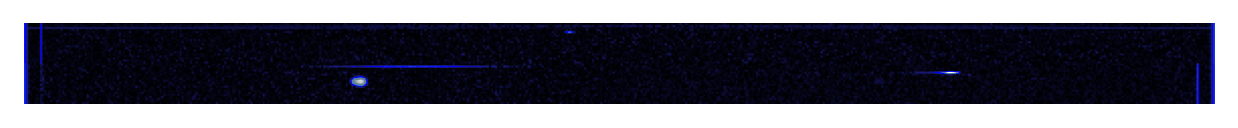

In [5]:
# Plot the image
fig, ax = plot_ccd_image(
    test_image,
    remove_overscan=True,
    orientation="vertical",
    # value_map=lambda x: x*(x < 2000) + 2000*(x > 2000),
)
plt.show()
# fig.savefig("skipper_data/figuras_informe/skipper_example_image.png")

## Display Distribution

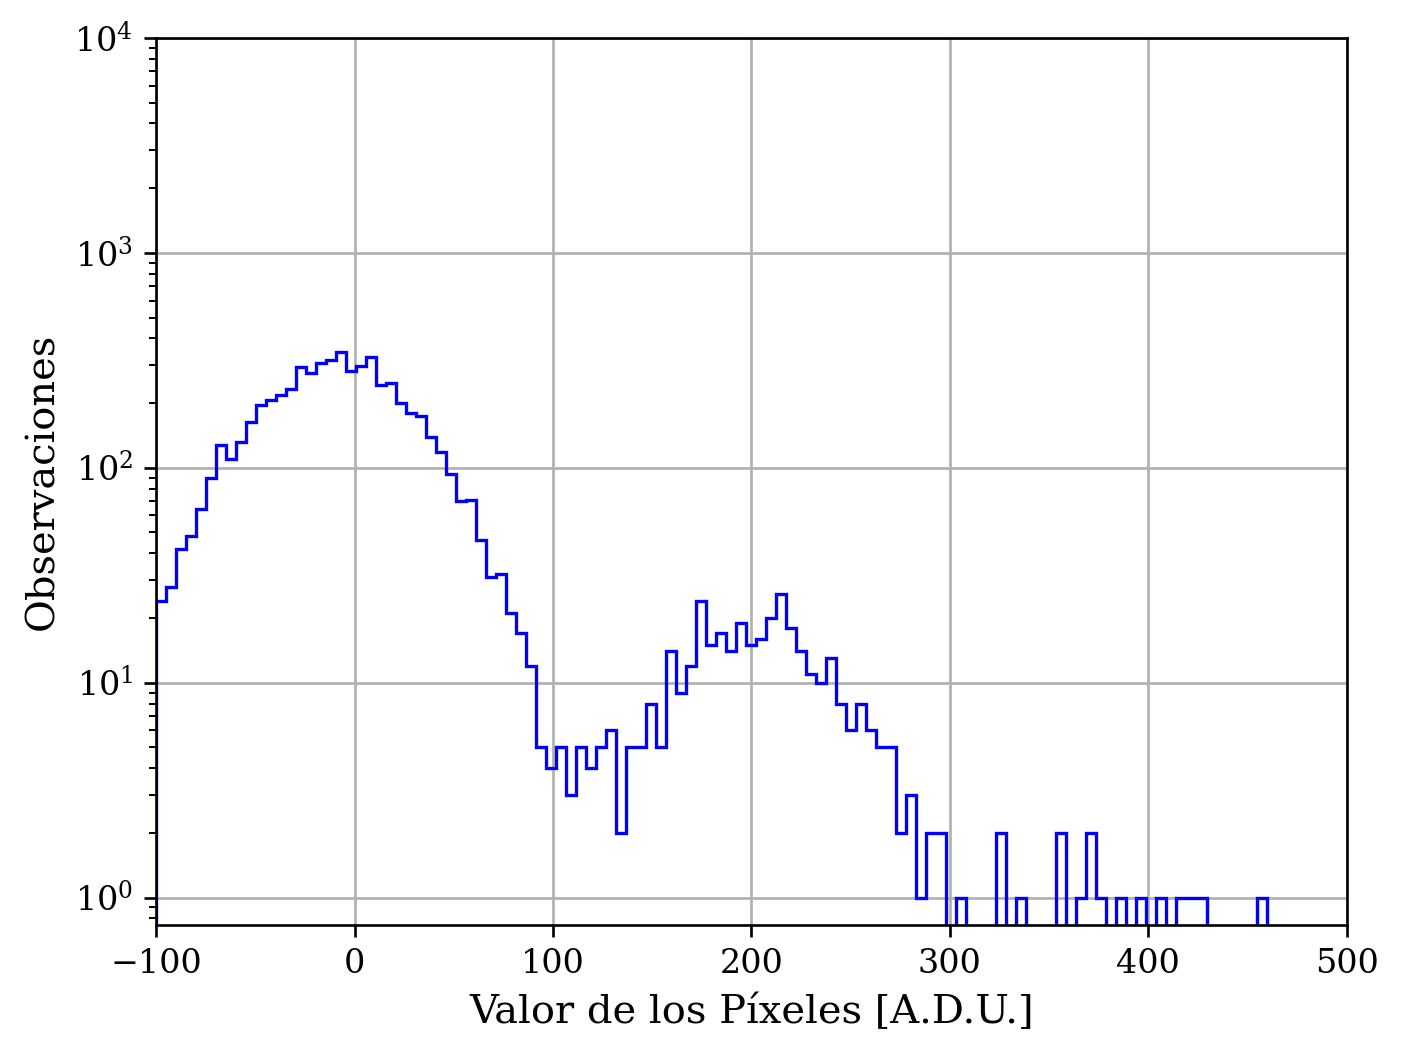

In [32]:
min_val = -1e2
tope = 0.5e3
n_bins = 120

test_frame = test_image[0].data  # append `[:, 10:]` to the line in order to fix error.
test_data = test_frame.flatten()

fig, ax = plt.subplots(1, 1)
if min_val is None:
    min_val = np.nanmin(test_data)
if tope is None:
    tope = np.nanmax(test_data)
ax.hist(
    test_data[(test_data > min_val) & (test_data < tope)],
    bins=np.linspace(min_val, tope, n_bins),
    histtype="step",
    color="blue",
)
ax.grid(True)
ax.set_yscale("log")
ax.set_yticks(10**np.arange(5))
ax.set_xlim(min_val, tope)
ax.set_xlabel("Valor de los Píxeles [A.D.U.]")
ax.set_ylabel("Observaciones")
plt.show()

# Cálculo de ganancia

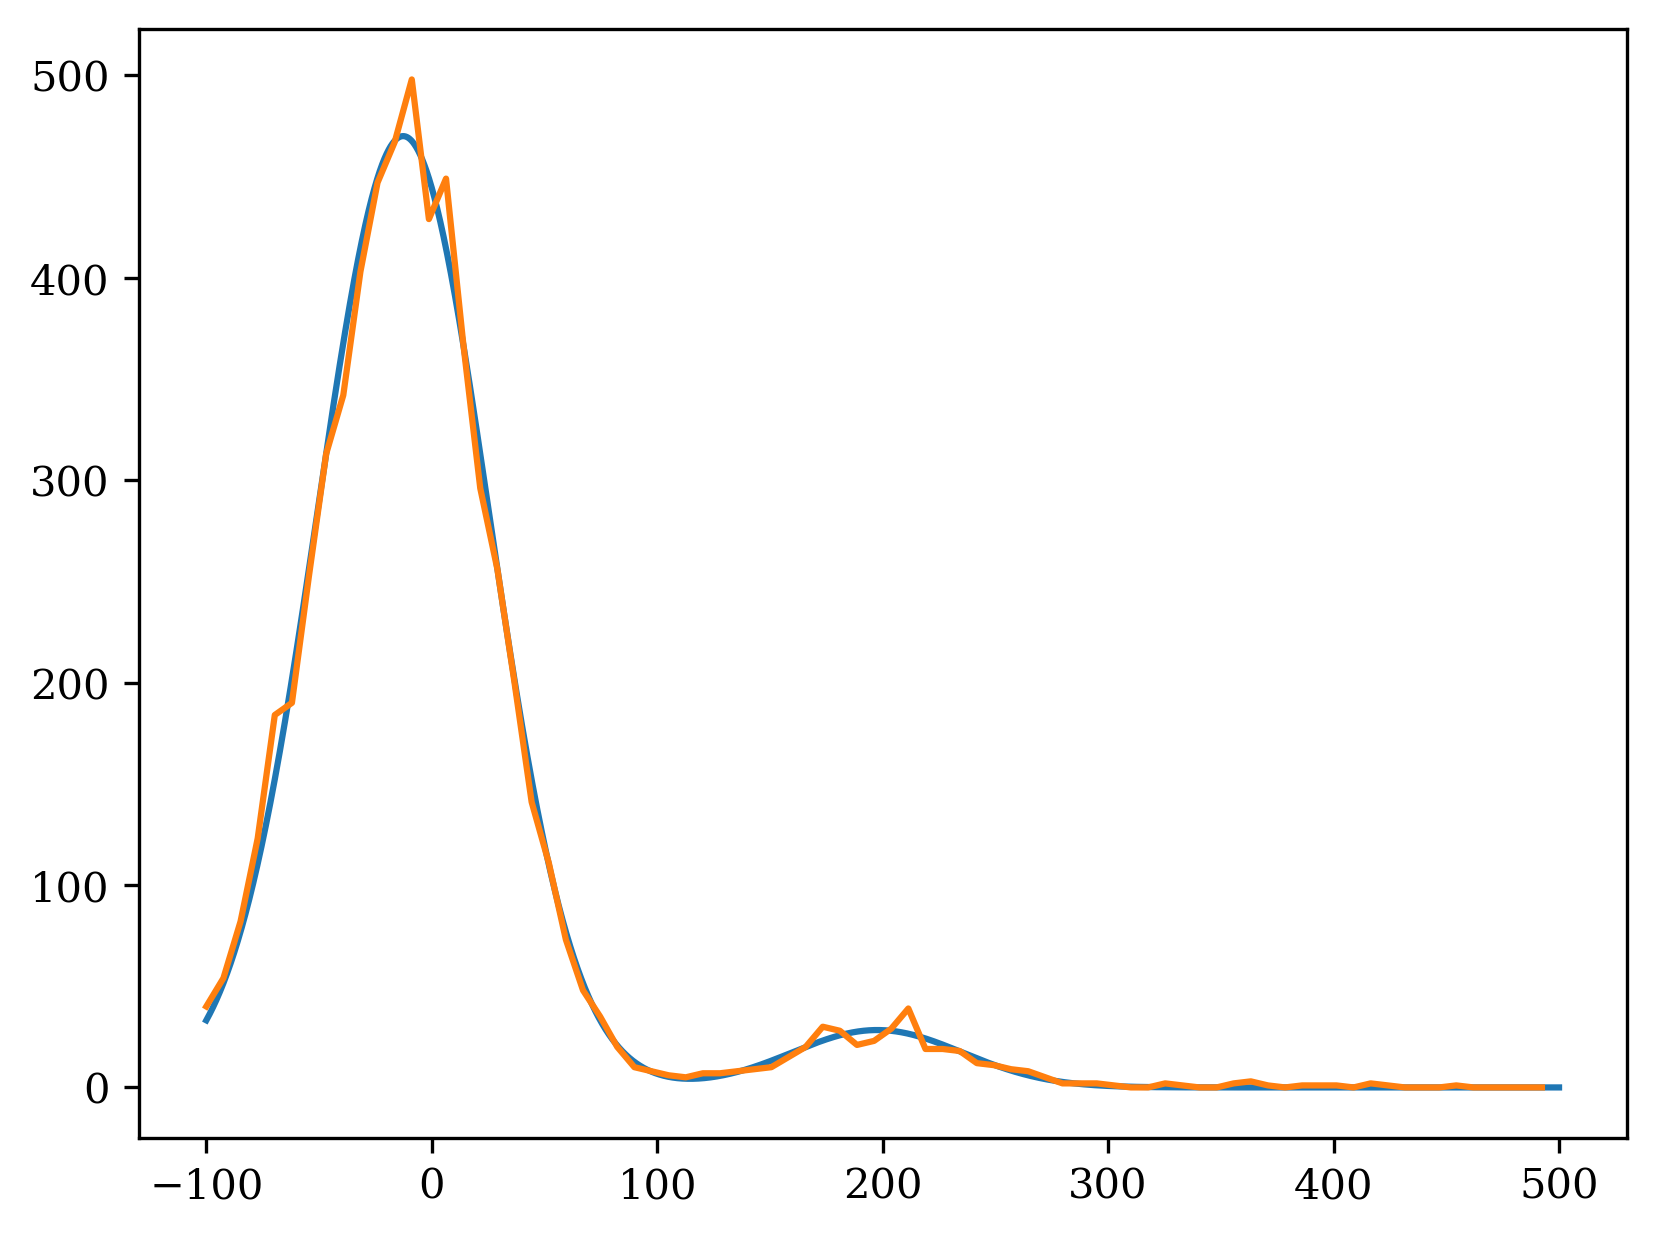

469.9970873428244 28.356296720934072 210.27566743397682 -12.68208461605784 37.92052311089163


In [34]:
def gaus_2(x, A, B, g, mu, sigma):
    return A *np.exp(-(x-mu)**2/(2*sigma**2)) + B * np.exp(-(x-g-mu)**2/(2*sigma**2))

min_val = -1e2
tope = 0.5e3
n_bins = 80

test_frame = test_image[0].data  # append `[:, 10:]` to the line in order to fix error.
test_data = test_frame.flatten()

if min_val is None:
    min_val = np.nanmin(test_data)
if tope is None:
    tope = np.nanmax(test_data)
value_counts, edges = np.histogram(
    test_data,
    bins=np.linspace(min_val, tope, n_bins), 
)

popt, pcov = curve_fit(gaus_2, edges[:-1], value_counts, 
                       p0 = [350, 25, 200, 0, 50])

A, B, g, mu, sigma = popt
adu = np.linspace(edges[0], edges[-1], 10000)
plt.figure(dpi = 150)
plt.plot(adu, gaus_2(adu, A, B, g, mu, sigma))
plt.plot(edges[:-1], value_counts)
plt.show()
print(A, B, g, mu, sigma)
